 <center style="font-size: 32px; font-weight: bold; ">
         Вычислительный граф
</center>

# Необходимые библиотеки

In [1]:
import numpy as np                                # работа с тензорами
import matplotlib.pyplot as plt                   # постороение графиков

from   time import perf_counter as tm             # время вычисления

import sys, numpy, matplotlib
print("python:    ", sys.version)
print("numpy:     ", numpy.__version__),
print("matplotlib:", matplotlib.__version__),

np.set_printoptions(precision=3, suppress=True)   # число цифр после точки в print

python:     3.7.6 (tags/v3.7.6:43364a7ae0, Dec 19 2019, 00:42:30) [MSC v.1916 64 bit (AMD64)]
numpy:      1.18.1
matplotlib: 3.2.0


# Динамический граф (мини PyTorch)¶

## Класс Tensor

In [94]:
import numpy as np

class Tensor: 
    node_id = 0                         # номер узла (статическое свойство)
    
    def __init__(self, val, args=None, fn=None):                
        self.data = np.array(val)       # хранимые данные
        self.grad = None                # градиент, входящий в узел
        self.fn   = fn                  # операция, вычисляемая узлом
        self.args = args                # список аргументов операции
        
        Tensor.node_id += 1
        self.id  =  Tensor.node_id      # номер создаваемого тензора
        
    def tensor(self, t):                # для констант в выражениях
        return t if isinstance(t, Tensor) else Tensor(t)            
        
    def __str__(self):                  # преобразование тензора в сторку
        return str(self.data)        
        
    def graph(self):                    
        """Весь граф из этого узла в аналитическом виде в строку"""
        if self.fn is None:
            return "x"+str(self.id)
        if len(self.args)==1:
            return self.fn+"("+self.args[0].graph()+")"
        if len(self.args)==2:
            return self.fn+"("+self.args[0].graph()+","+self.args[1].graph()+")"
                
    def add(self, t):                   # сложение
        t = self.tensor(t)
        return Tensor(self.data + t.data, [self, t], "add")

    def sub(self, t):                   # вычитание
        t = self.tensor(t)
        return Tensor(self.data - t.data, [self, t], "sub")    

    def mul(self, t):                   # умножение без свёртки
        t = self.tensor(t)
        return Tensor(self.data * t.data, [self, t], "mul")    
        
    def dot(self, v):                   # скалярное произведение векторов
        v = self.tensor(v)
        return Tensor(np.dot(self.data, v.data), [self, v], "dot")

    def mv(self, v):                    # свёртка матрицы и вектора
        v = self.tensor(v)
        return Tensor(np.dot(self.data, v.data), [self, v], "mv")

    def mm(self, n):                    # свёртка матриц
        n = self.tensor(n)
        return Tensor(np.dot(self.data, n.data), [self, n], "mm")
        
    def __add__(self, t):  return  self.add(t) 
    def __sub__(self, t):  return  self.sub(t)
    def __mul__(self, t):  return  self.mul(t)
    
    def backward(self, grad = 1):
        if self.grad is None:
            self.grad = grad
        else:                           # накапливаем входящие градиенты
            self.grad += grad
        
        if   self.fn == "add":          # сложение
            self.args[0].backward( grad)
            self.args[1].backward( grad)            
            
        elif self.fn == "sub":          # вычитание
            self.args[0].backward( grad)
            self.args[1].backward(-grad)                        
            
        elif self.fn in ["dot", "mul"]: # свёртка векторов или умножение  тензоров
            self.args[0].backward( grad * self.args[1].data)
            self.args[1].backward( self.args[0].data * grad) 
       
        elif self.fn == "mv":          # свёртка матрицы и вектора  
            self.args[0].backward( np.outer(grad, self.args[1].data))
            self.args[1].backward( np.dot(grad, self.args[0].data))     
    
        elif self.fn == "mm":          # свёртка двух матриц
            self.args[0].backward( np.dot(grad, self.args[1].data.T))
            self.args[1].backward( np.dot(self.args[0].data.T, grad))                               

## Пример использования

In [113]:
v = Tensor([1,2])              # создаём вектор
m = Tensor(np.eye(2))          # создаём единичную матрицу
n = Tensor(np.ones((2,2)))     # создаём матрицу из единиц

z = m.mm(n).mv(v).dot(v)       # строим вычислительный граф

z.backward()                   # вычисляем градиенты

print(z)                       # 9.0
print(v.grad)                  # [6. 6.]
print(m.grad)                  # [[3. 3.]
                               #  [6. 6.]]
print(n.grad)                  # [[1. 2.]
                               #  [2. 4.]]

9.0
[6. 6.]
[[3. 3.]
 [6. 6.]]
[[1. 2.]
 [2. 4.]]


In [111]:
import torch

v = torch.tensor([1.,2.],   requires_grad=True, dtype=torch.float)
m = torch.tensor(np.eye(2), requires_grad=True, dtype=torch.float) 
n = torch.ones  (2,2,       requires_grad=True) 
 
z = m.mm(n).mv(v).dot(v)

z.backward()
 
print(z)      # tensor(9.)
print(v.grad) # tensor( [ 6., 6.]) 
print(m.grad) # tensor( [ 6., 6.]) 
print(n.grad) # tensor([[ 1., 2.],
              #         [2.,  4.]])

tensor(9., grad_fn=<DotBackward>)
tensor([6., 6.])
tensor([[3., 3.],
        [6., 6.]])
tensor([[1., 2.],
        [2., 4.]])


## Пример с нескалярным корнем

In [119]:
v = Tensor([1,2])              # создаём вектор
m = Tensor(np.eye(2))          # создаём единичную матрицу
n = Tensor(np.ones((2,2)))     # создаём матрицу из единиц

z = m.mul(n).mv(v)              # строим вычислительный граф

z.backward(np.ones((2,)))      # вычисляем градиенты

print(z)                       # 9.0
print(v.grad)                  # [6. 6.]
print(m.grad)                  # [[3. 3.]
                               #  [6. 6.]]
print(n.grad)                  # [[1. 2.]
                               #  [2. 4.]]

[1. 2.]
[1. 1.]
[[1. 2.]
 [1. 2.]]
[[1. 0.]
 [0. 2.]]


In [120]:
import torch

v = torch.tensor([1.,2.],   requires_grad=True, dtype=torch.float)
m = torch.tensor(np.eye(2), requires_grad=True, dtype=torch.float) 
n = torch.ones  (2,2,       requires_grad=True) 
 
z = m.mul(n).mv(v)

z.backward(torch.ones(2))
 
print(z)      # tensor(9.)
print(v.grad) # tensor( [ 6., 6.]) 
print(m.grad) # tensor( [ 6., 6.]) 
print(n.grad) # tensor([[ 1., 2.],
              #         [2.,  4.]])

tensor([1., 2.], grad_fn=<MvBackward>)
tensor([1., 1.])
tensor([[1., 2.],
        [1., 2.]])
tensor([[1., 0.],
        [0., 2.]])


In [123]:
v = torch.tensor([-1.,2.],   requires_grad=True, dtype=torch.float)
z = v.sum() 
z.backward()
print(z)
print(v.grad)

tensor(1., grad_fn=<SumBackward0>)
tensor([1., 1.])


# Статический граф (мини Tensorflow)

## Классы - узлы вычислительного графа

In [2]:
#-------------------------- прототип всех узлов:
class Node:
    node_id = 0                               # номер узла
    
    def __init__(self, name = None):
        Node.node_id += 1 
        self.name = name if name and len(name) > 0 else "n" + str(Node.node_id)
    
    def __str__(self):
        return self.name                      # перевод в строку

    def clear_grad(self):
        self.grad = 0                         # очистка градиента
    
    def set_grad(self, g):
        self.grad += g                        # установка градиента
        
#-------------------------- узел переменной:
class Variable(Node):
    def __init__(self, v1, name = None):
        super().__init__(name) 
        
        self.value = v1                      # значение переменной
        self.delta_value = 0                 # предыдущее измение в SGD
        
        if hasattr(v1, 'ndim') and v1.ndim > 2 :
            print("Value can be matrix or vector!!!")
        
    def eval(self):
        return self.value                    # пересчёт значения узлов
    
    def SGD(self, lr=0.5, momentum=0.8):
        self.delta_value = self.delta_value * momentum - lr*self.grad
        self.value       = self.value + self.delta_value
    
#-------------------------- прототип узла с двумя входами:
class NodeBin(Node):
    def __init__(self, v1, v2, name = None):
        super().__init__(name)
        self.v1 = v1
        self.v2 = v2
        
    def to_str(self, op): return  "(" + str(self.v1) + op + str(self.v2) + ")"        

    def clear_grad(self):
        self.grad = 0                         # очистка градиента
        self.v1.clear_grad()
        self.v2.clear_grad()
    

#-------------------------- прототип узла с одним входом:
class NodeOne(Node):
    def __init__(self, v1, name = None):
        super().__init__(name)
        self.v1 = v1
        
    def to_str(self, op): return  op + "(" + str(self.v1) + ")"        
    
    def clear_grad(self):
        self.grad = 0                         # очистка градиента
        self.v1.clear_grad()
    
#-------------------------- сложение матриц или матрицы и вектора:
class Add(NodeBin):
    def __str__(self): return self.to_str("+")    

    def eval(self):   
        self.value = self.v1.eval() + self.v2.eval()        
        return self.value
    
    def set_grad(self, g):
        self.grad += g
        self.v1.set_grad(g if g.ndim == self.v1.value.ndim else np.sum(g, axis=0))    
        self.v2.set_grad(g if g.ndim == self.v2.value.ndim else np.sum(g, axis=0))

#-------------------------- вычитание матриц или матрицы и вектора:
class Sub(NodeBin):
    def __str__(self): return self.to_str("-")    

    def eval(self):   
        self.value = self.v1.eval() - self.v2.eval()        
        return self.value
    
    def set_grad(self, g):
        self.grad += g
        self.v1.set_grad( g if g.ndim == self.v1.value.ndim else  np.sum(g, axis=0))     
        self.v2.set_grad(-g if g.ndim == self.v2.value.ndim else -np.sum(g, axis=0))
        
#-------------------------- простое умножение тезоров:
class Mult(NodeBin):
    def __str__(self): return self.to_str("*")    

    def eval(self):   
        self.value = self.v1.eval() * self.v2.eval()
        return self.value

    def set_grad(self, g):
        self.grad += g    
        self.v1.set_grad(g * self.v2.value)  
        self.v2.set_grad(self.v1.value * g)        

#-------------------------- свёртка тезоров:        
class MMult(NodeBin):        
    def __str__(self): return self.to_str(" dot ")            
    
    def eval(self):   
        self.value = np.dot(self.v1.eval(), self.v2.eval() )
        return self.value
    
    def set_grad(self, g):
        self.grad += g
        self.v1.set_grad( np.dot(g, self.v2.value.T) )
        self.v2.set_grad( np.dot(self.v1.value.T, g) )
        
#-------------------------- сумма квадратов всех компонент тензора:        
class Sum2(NodeOne):        
    def __str__(self): return self.to_str("sum2")            
    
    def eval(self):   
        v1 = self.v1.eval()
        self.value = np.mean( v1*v1 )  
        return self.value
    
    def set_grad(self, g=1):
        self.grad += g
        self.v1.set_grad( ((2/self.v1.value.size)*g) * self.v1.value )        

## Пример графа и его градиента

In [3]:
Node.node_id = 0                              # r = x1 @ ( (x1 + x2)*5 )  
x1 = Variable(np.array([1,2]), "x1")          # dr/dx1 = 10*x1 + 5*x2
x2 = Variable(np.array([3,4]), "x2")          # dr/dx2  = 5*x1

r1 = Add(x1, x2)
r2 = Mult(r1, Variable(5, "5"))
r  = MMult(x1,r2)

r.eval()
r.clear_grad()
r.set_grad(1)

print("graph:", str(r), "=", r.value)
print("grad: ", x1.grad, x2.grad)

graph: (x1 dot ((x1+x2)*5)) = 80
grad:  [25 40] [ 5 10]


## Данные для линейной регрессии

In [4]:
import numpy as np
import matplotlib.pyplot as plt    # постороение графиков
np.set_printoptions(precision=3, suppress=True)

nPoints = 1000                     # число точек
nInp    = 2                        # число входов (число признаков)
nOut    = 3                        # число выходов модели

w = np.array([[  1,  3,  5],
              [  2,  4,  6] ])
b = np.array( [ -1, -2, -3]  )

X = np.random.random ((nPoints, nInp))                   # (100,3)

Y = np.dot(X, w) + b  + np.random.normal (0, 0.01, (nPoints,nOut))      

print("X:", X.shape," Y:", Y.shape)

X: (1000, 2)  Y: (1000, 3)


## Граф

In [5]:
node_x = Variable(X, name="x")                                 
node_w = Variable(np.random.random ((nInp,nOut)), name="w")  # случайные значения
node_b = Variable(np.random.random ((nOut, )),    name="b")  # случайные значения

node_y = Add( MMult(node_x, node_w), node_b, name="y")
node_Y = Variable(Y, name="Y")

node_L = Sum2(Sub(node_y, node_Y), name="loss")              # граф вычисления ошибки

print("Model:", str(node_L))

Model: sum2((((x dot w)+b)-Y))


## Основной цикл вычислений:

 79.0 ms


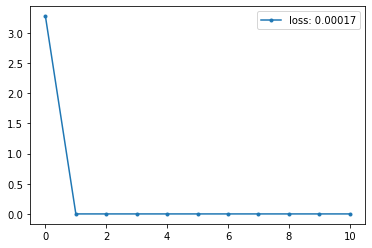

[[1.001 2.999 5.002]
 [1.988 4.003 6.   ]]
[-1.007 -1.996 -2.999]


In [6]:
batch_size = 10     # размер батча в SGD
lr         = 2      # скорость обучение                                 
momentum   = 0.5    # инертность смещения

tm1 = tm()

node_x.value, node_Y.value = X, Y                    # по всем данным
losses = [ node_L.eval() ]                           # вычисляем начальную ошибку

for epoch in range(10):                              # эпоха - проход по всем примерам
    for i in range(0, X.shape[0] ,batch_size):       # примеры разбиты на пачки batch_size
        node_x.value = X[i:i+batch_size, :]          # пачка входов в модель
        node_Y.value = Y[i:i+batch_size, :]          # пачка желаемых выходов
        
        node_L.eval()                                # вычисляем ошибку
        node_L.clear_grad()                          # обнуляем градиенты
        node_L.set_grad(1)                           # вычисляем градиенты (обратная ошибка)
        
        node_w.SGD(lr, momentum)                     # меняем параметры
        node_b.SGD(lr, momentum) 
        
    node_x.value, node_Y.value = X, Y                # по всем данным
    losses.append( node_L.eval() )                   # вычисляем текущую ошибку
    

print(" %.1f ms" % ( (tm()-tm1)*1000) )
    
plt.plot(losses, marker=".")
plt.legend(["loss: %.5f"  % ( node_L.value )])
plt.show()
    
print(node_w.value)
print(node_b.value)